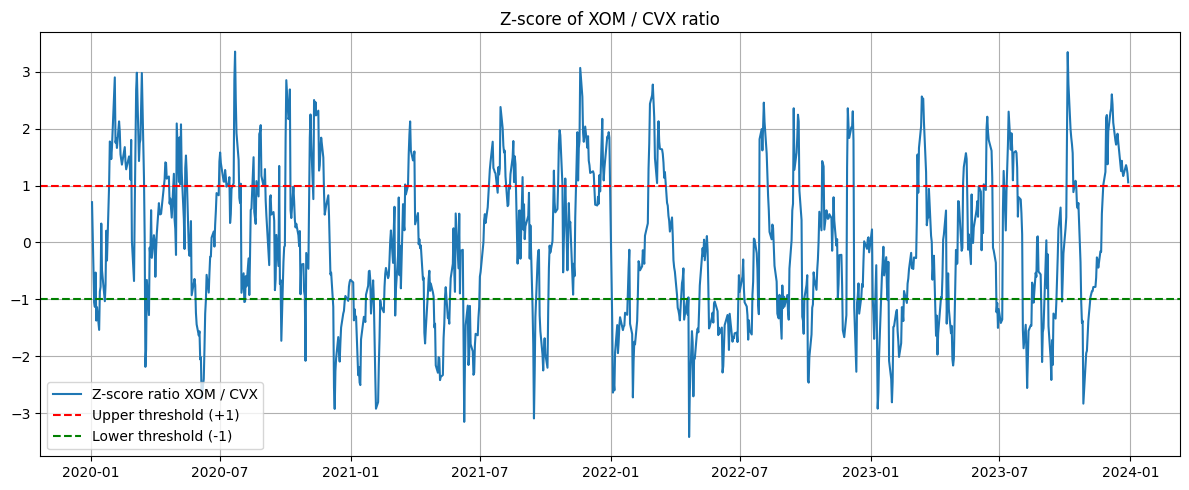

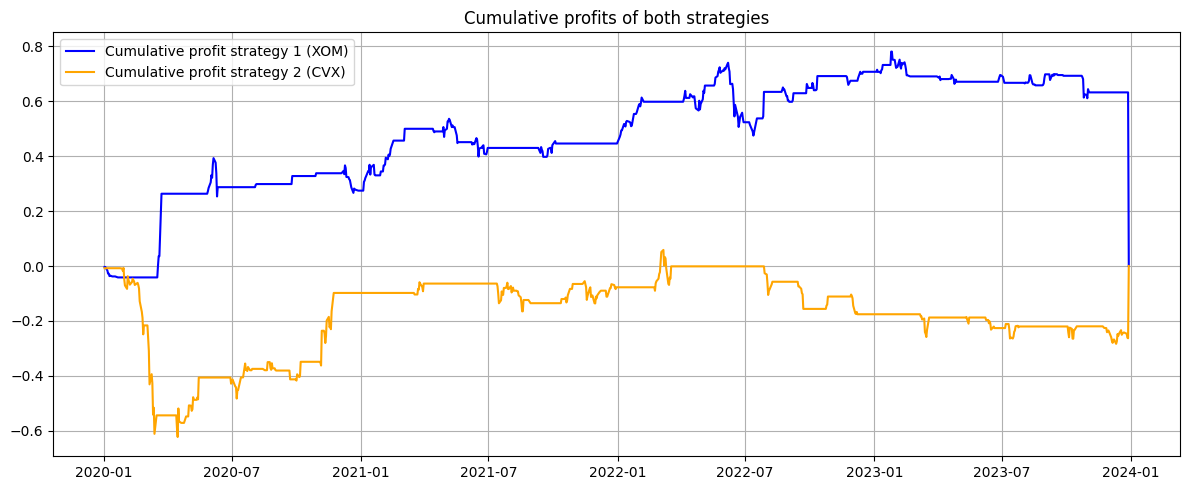

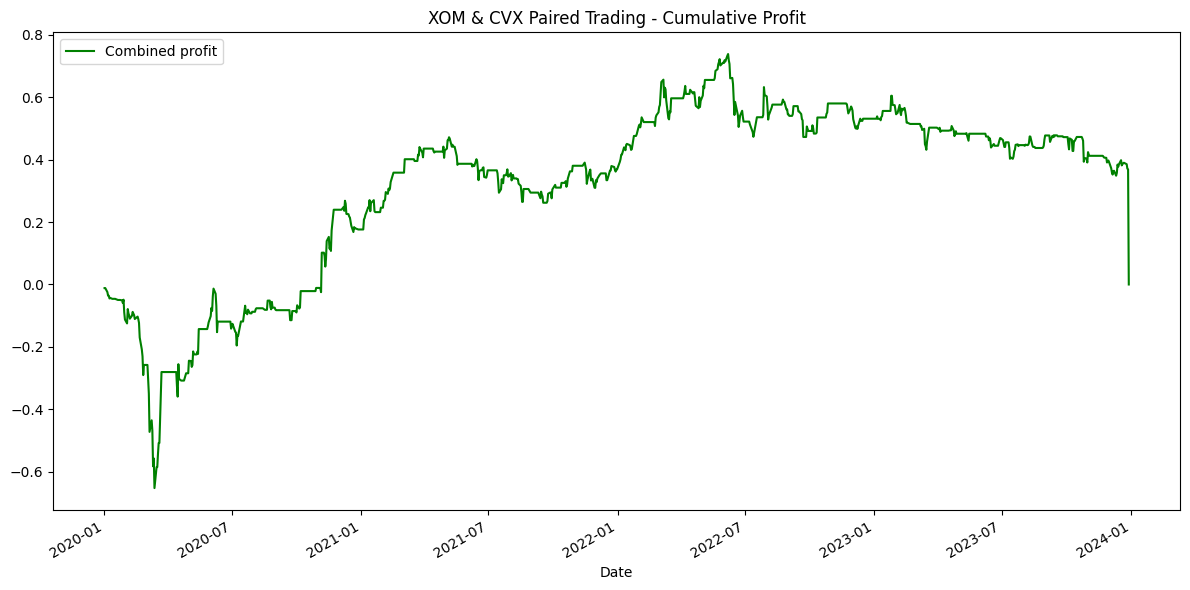

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load data ===
df = pd.read_csv("/Users/mounir/Desktop/TP VS CODE/project/data/price_data.csv", index_col=0, parse_dates=True)
XOM_ts = df["XOM"]
CVX_ts = df["CVX"]

# === Generate trading signals using Z-score of the price ratio ===
def signals_zscore_ratio(y1, y2, window_size=20, first_ticker=True):
    ratio = y1 / y2
    rolling_mean = ratio.rolling(window=window_size, min_periods=1).mean()
    rolling_std = ratio.rolling(window=window_size, min_periods=1).std()
    z_scores = (ratio - rolling_mean) / rolling_std

    buy = ratio.copy()
    sell = ratio.copy()

    if first_ticker:
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0

    signals_df = pd.DataFrame(index=y1.index)
    signals_df["signal"] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df["orders"] = signals_df["signal"].diff()
    signals_df.loc[signals_df["orders"] == 0, "orders"] = None
    return signals_df, z_scores

# === Compute cumulative strategy returns ===
def calculate_profit(signals_df, price_ts):
    returns = price_ts.pct_change().fillna(0)
    strategy_returns = returns.shift(-1) * signals_df["signal"]
    return np.cumsum(strategy_returns).fillna(0)

# === Strategy 1: XOM as trading asset ===
signals_df1, z1 = signals_zscore_ratio(XOM_ts, CVX_ts, first_ticker=True)
profit_df1 = calculate_profit(signals_df1, XOM_ts)

# === Strategy 2: CVX as trading asset ===
signals_df2, z2 = signals_zscore_ratio(XOM_ts, CVX_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, CVX_ts)

# === Plot Z-scores of the ratio ===
plt.figure(figsize=(12, 5))
plt.plot(z1, label='Z-score ratio XOM / CVX')
plt.axhline(1, color='red', linestyle='--', label='Upper threshold (+1)')
plt.axhline(-1, color='green', linestyle='--', label='Lower threshold (-1)')
plt.title("Z-score of XOM / CVX ratio")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === Plot cumulative profits of both strategies ===
plt.figure(figsize=(12, 5))
plt.plot(profit_df1, label='Cumulative profit strategy 1 (XOM)', color='blue')
plt.plot(profit_df2, label='Cumulative profit strategy 2 (CVX)', color='orange')
plt.title("Cumulative profits of both strategies")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === Plot combined cumulative profit ===
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
cumulative_profit_combined.plot(label='Combined profit', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title('XOM & CVX Paired Trading - Cumulative Profit')
plt.tight_layout()
plt.show()
